In [4]:
import random
import sqlite3
import json
import os

import numpy as np
import pandas as pd

import networkx as nx
from networkx.readwrite import json_graph

PATH_BD = 'data/CNPJ_full.db'

In [5]:
%%time
connection = sqlite3.connect(PATH_BD)
con = connection.cursor()

Wall time: 1e+03 µs


In [6]:
item = '05150869000136'
item = item.replace('.','').replace('/','').replace('-','').zfill(14)
item

'05150869000136'

In [7]:
conBD = sqlite3.connect(PATH_BD)
path = os.path.join('Grafo', 'grafo.html')
COL_FLOAT64 = ['capital_social']
QUALIFICACOES = {
    '05':'Administrador',
    '08':'Conselheiro de Administração',
    '10':'Diretor', 
    '16':'Presidente', 
    '17':'Procurador',
    '20':'Sociedade Consorciada', 
    '21':'Sociedade Filiada', 
    '22':'Sócio', 
    '23':'Sócio Capitalista', 
    '24':'Sócio Comanditado', 
    '25':'Sócio Comanditário', 
    '26':'Sócio de Indústria', 
    '28':'Sócio-Gerente', 
    '29':'Sócio Incapaz ou Relat.Incapaz (exceto menor)', 
    '30':'Sócio Menor (Assistido/Representado)', 
    '31':'Sócio Ostensivo', 
    '37':'Sócio Pessoa Jurídica Domiciliado no Exterior', 
    '38':'Sócio Pessoa Física Residente no Exterior', 
    '47':'Sócio Pessoa Física Residente no Brasil', 
    '48':'Sócio Pessoa Jurídica Domiciliado no Brasil', 
    '49':'Sócio-Administrador', 
    '52':'Sócio com Capital', 
    '53':'Sócio sem Capital', 
    '54':'Fundador', 
    '55':'Sócio Comanditado Residente no Exterior', 
    '56':'Sócio Comanditário Pessoa Física Residente no Exterior', 
    '57':'Sócio Comanditário Pessoa Jurídica Domiciliado no Exterior', 
    '58':'Sócio Comanditário Incapaz', 
    '59':'Produtor Rural', 
    '63':'Cotas em Tesouraria', 
    '65':'Titular Pessoa Física Residente ou Domiciliado no Brasil', 
    '66':'Titular Pessoa Física Residente ou Domiciliado no Exterior', 
    '67':'Titular Pessoa Física Incapaz ou Relativamente Incapaz (exceto menor)', 
    '68':'Titular Pessoa Física Menor (Assistido/Representado)', 
    '70':'Administrador Residente ou Domiciliado no Exterior', 
    '71':'Conselheiro de Administração Residente ou Domiciliado no Exterior', 
    '72':'Diretor Residente ou Domiciliado no Exterior', 
    '73':'Presidente Residente ou Domiciliado no Exterior', 
    '74':'Sócio-Administrador Residente ou Domiciliado no Exterior', 
    '75':'Fundador Residente ou Domiciliado no Exterior'
}

In [8]:
G = nx.DiGraph()

In [9]:
type(G)

networkx.classes.digraph.DiGraph

In [10]:
# Antes de gerar esse formato, necessario adaptar alguns atributos do grafo
G_adapt = G.copy()

In [11]:
pos = nx.spring_layout(G_adapt, dim=4, scale=1000)

In [12]:
for node in G_adapt.nodes:
    tipo_pessoa = G_adapt.nodes[node]['tipo_pessoa']

    G_adapt.nodes[node]['label'] = G_adapt.nodes[node]['nome']

    # Configura atributos de visualizacao necessarios para alguns leitores
    G_adapt.nodes[node]['viz'] = {'size':10}

    if tipo_pessoa == 1:
        if G_adapt.nodes[node]['situacao'] == '02':
            G_adapt.nodes[node]['viz']['color'] = {'a':1,'r':1,'g':57,'b':155}
        else:
            G_adapt.nodes[node]['viz']['color'] = {'a':1,'r':255,'g':0,'b':0}
    else:
        G_adapt.nodes[node]['viz']['color'] = {'a':1,'r':46,'g':125,'b':32}

    G_adapt.nodes[node]['viz']['position'] = {'x':pos[node][0],
                                              'y':pos[node][1],
                                              'z':5}

    # Converte cols para float, por incompatibilidade do nx com o numpy.float64
    for coluna in COL_FLOAT64:
        if coluna in G_adapt.nodes[node]:
            G_adapt.nodes[node][coluna] = float(G_adapt.nodes[node][coluna])

In [13]:
nx.write_gexf(G_adapt, path)

In [14]:
def consulta_item(rede, tipo_item, item):
    if tipo_item == 'cnpj':
        #print('Consultando CNPJ: {}'.format(item))
        rede.insere_pessoa(1, item.replace('.','').replace('/','').replace('-','').zfill(14))

    elif tipo_item == 'nome_socio':
        #print('Consultando socios com nome: {}'.format(item))
        rede.insere_com_cpf_ou_nome(nome=item.upper())

    elif tipo_item == 'cpf':
        cpf = mascara_cpf(item.replace('.','').replace('-',''))
        #print('Consultando socios com cpf (mascarado): {}.'.format(cpf))
        rede.insere_com_cpf_ou_nome(cpf=cpf)

    elif tipo_item == 'cpf_nome':
        cpf = mascara_cpf(item[:11])
        nome = item[11:]

        #print('Consultando socio com cpf (mascarado) {} e nome {}'.format(cpf,nome))
        rede.insere_pessoa(2,(cpf,nome))

        # Se nao tem vinculo, nao existe socio com esse par cpf e nome
        if len(rede.dataframe_vinculos()) == 0:
            print('Nenhum socio encontrado com cpf "{}" e nome "{}"'.format(cpf, nome))
            rede.G.remove_node(cpf+nome)
    else:
        print('Tipo de consulta invalido: {}.\nTipos possiveis: cnpj, nome_socio, cpf, cpf_nome'.format(tipo_item))

In [15]:
tipo_pessoa = 1
id_pessoa = item
atributos=None
nivel=0
origem=None
nivel_max=3
qualificacoes = 'TODAS'

In [23]:
def vinculos(tipo_pessoa, id_pessoa, atributos=None, nivel=0, origem=None):
    nome = None

    # Monta o id do node de acordo com o tipo de pessoa
    if tipo_pessoa == 1:
        id_pessoa_str = id_pessoa
    else:
        nome = id_pessoa[1]
        id_pessoa_str = id_pessoa[0] + nome

    # Nova pessoa
    if id_pessoa_str not in G:
        nova_pessoa = True

        if atributos:
            G.add_node(id_pessoa_str, nome=nome, tipo_pessoa=tipo_pessoa, nivel=nivel, **atributos)
        else:
            G.add_node(id_pessoa_str, nome=nome, tipo_pessoa=tipo_pessoa, nivel=nivel)
        if (tipo_pessoa == 1):
            # Atualizacao: pega do banco apenas se dados nao vieram como parametro
            if not atributos:
                sql = '''
                        SELECT EST.CNPJ || EST.CNPJ_ORDEM || EST.CNPJ_DV as CNPJ_x, EST.CNPJ AS CNPJ,
                                EMP.RAZAO as razao_social, EST.NOME as nome_fantasia
                                FROM ESTABELECIMENTOS as EST
                                    LEFT JOIN EMPRESAS as EMP
                                        ON EST.CNPJ = EMP.CNPJ
                                WHERE 
                                    EST.CNPJ = '{0}' AND
                                    EST.MATRIZ_FILIAL = 1 
                    '''.format(id_pessoa[:8])

                try:
                    empresa = pd.read_sql_query(sql, conBD).iloc[0,:] # pega primeiro registro
                    #display(empresa)
                    for k, v in empresa.items():
                        G.nodes[id_pessoa_str][k] = v

                except:
                    print('Empresa nao encontrada: {}'.format(id_pessoa_str))
                    G.remove_node(id_pessoa_str)
                    raise KeyError
            if (str(G.nodes[id_pessoa_str]['nome_fantasia']).strip() == '') or \
                            (str(G.nodes[id_pessoa_str]['nome_fantasia']).strip() == 'NAO POSSUI' or \
                            (str(G.nodes[id_pessoa_str]['nome_fantasia']).strip() == 'None' )):
                G.nodes[id_pessoa_str]['nome'] = G.nodes[id_pessoa_str]['razao_social'] 
            else:
                G.nodes[id_pessoa_str]['nome'] = G.nodes[id_pessoa_str]['nome_fantasia']
        else:
            # Se no for pessoa fisica
            G.nodes[id_pessoa_str]['cpf'] = id_pessoa[0]
    else:
        nova_pessoa = False
        nivel_anterior = G.nodes[id_pessoa_str]['nivel']

        if nivel < nivel_anterior:
            G.nodes[id_pessoa_str]['nivel'] = nivel

    if (nivel < nivel_max) and (nova_pessoa or nivel < nivel_anterior):   
                # obtem todas as relacoes de sociedades que envolvam esse PJ ou PF

                # Verifica se relacionados ja estao no grafo ou se precisa buscar no BD
                if (not nova_pessoa) and (nivel_anterior < __nivel_max):
                    # Relacionados ja estao no grafo, nao precisa buscar no BD

                    # navega para os socios
                    for id_socio_str in G.predecessors(id_pessoa_str):
                        node_socio = G.nodes[id_socio_str]
                        tipo_socio = node_socio['tipo_pessoa']

                        if tipo_socio == 1:
                            # socio eh PJ
                            socio = id_socio_str
                        else:
                            # socio eh PF
                            socio = (node_socio['cpf'],node_socio['nome'])

                        vinculos(tipo_pessoa=tipo_socio, id_pessoa=socio, nivel=nivel+1, origem=id_pessoa)

                    # navega para empresas das quais e socio
                    for empresa in self.G.successors(id_pessoa_str):
                        vinculos(tipo_pessoa=1, id_pessoa=empresa, nivel=nivel+1, origem=id_pessoa)

                else:
                    # Relacionados ainda nao estao no grafo; buscar no BD.
                    # (A) busca EMPRESAS das quais esta PJ/PF eh socia
                    sql = '''
                        SELECT CNPJ as s_cnpj, 
                                QUALIFICACAO s_cod_qualificacao,
                                DATA_ENTRADA_SOCIEDADE s_data_entrada,
                                IDENTIFICADOR_SOCIO, NOME, CPF_CNPJ, 
                                CODIGO_PAIS, CPF_REPRESENTANTE_LEGAL,
                                NOME_REPRESENTANTE_LEGAL, QUALIFICACAO_REPRESENTANTE_LEGAL, FAIXA_ETARIA
                        FROM SOCIOS
                        '''

                    if tipo_pessoa == 1:
                        sql += '''
                            WHERE
                                CPF_CNPJ LIKE '{0}'
                        '''.format(id_pessoa[:8] + '%')
                    else:
                        sql += '''
                            WHERE CPF_CNPJ LIKE '{0}' AND 
                                  NOME = '{1}'
                        '''.format(id_pessoa[0][:8],id_pessoa[1])

                    empresas = pd.read_sql_query(sql, conBD)

                    for _, empresa in empresas.iterrows():
                        cod_qualificacao = empresa['s_cod_qualificacao']

                        # Apenas adiciona relacionamento se for qualificacao de interesse
                        if (__qualificacoes == 'TODAS') | (cod_qualificacao in __qualificacoes): 
                            cnpj = empresa['s_cnpj']
                            data_entrada = empresa['s_data_entrada']

                            if __qualificacoes != 'TODAS':
                                qualificacao = __qualificacoes[cod_qualificacao]
                            else:
                                qualificacao = cod_qualificacao     

                            # se a empresa nao for a origem desse pulo
                            if cnpj != origem:
                                atributos = dict(empresa.drop(['s_cnpj','s_cod_qualificacao','s_data_entrada']))

                                # chama recursivamente para tratar a PJ
                                _vinculos(tipo_pessoa=1, id_pessoa=cnpj, nivel=nivel+1, origem=id_pessoa, atributos=atributos)

                                # adiciona aresta de socio para empresa em questao
                                G.add_edge(id_pessoa_str, 
                                                cnpj, 
                                                tipo='socio', 
                                                cod_qualificacao=cod_qualificacao,
                                                qualificacao=qualificacao, 
                                                data_entrada=data_entrada)


                    # (B) SOCIOS desta PJ (apenas se matriz)
                    if tipo_pessoa == 1 and (G.nodes[id_pessoa_str]['matriz_filial'] == '1'):
                        sql = '''
                            SELECT CNPJ as cnpj, 
                                IDENTIFICADOR_SOCIO as tipo_socio, 
                                CPF_CNPJ as cnpj_cpf_socio, 
                                NOME as nome_socio, 
                                QUALIFICACAO as cod_qualificacao, 
                                DATA_ENTRADA_SOCIEDADE as data_entrada 
                            FROM SOCIOS
                            WHERE
                                cnpj = '{0}'
                        '''.format(id_pessoa[:8])

                        socios = pd.read_sql_query(sql, conBD)

                        for _, socio in socios.iterrows():
                            cod_qualificacao = socio['cod_qualificacao']

                            # Apenas adiciona relacionamento se for qualificacao de interesse
                            if (qualificacoes == 'TODAS') | (cod_qualificacao in qualificacoes): 
                                cnpj_cpf_socio = socio['cnpj_cpf_socio']
                                nome_socio = socio['nome_socio']
                                tipo_socio = int(socio['tipo_socio'])
                                data_entrada = socio['data_entrada']
                                if qualificacoes != 'TODAS':
                                    qualificacao = qualificacoes[cod_qualificacao]
                                else:
                                    qualificacao = cod_qualificacao

                                if tipo_socio == 1:
                                    # socio eh PJ
                                    id_socio = cnpj_cpf_socio
                                    socio_str = id_socio
                                else:
                                    # socio eh PF
                                    id_socio = (cnpj_cpf_socio,nome_socio)
                                    socio_str = cnpj_cpf_socio + nome_socio

                                # se o socio nao for a origem desse pulo
                                    # chama recursivamente para tratar a nova PJ/PF
                                    vinculos(tipo_pessoa=tipo_socio, id_pessoa=id_socio, nivel=nivel+1, origem=id_pessoa)

                                    # adiciona aresta de socio para empresa em questao
                                    self.G.add_edge(socio_str, 
                                                    id_pessoa_str, 
                                                    tipo='socio', 
                                                    cod_qualificacao=cod_qualificacao,
                                                    qualificacao=qualificacao, 
                                                    data_entrada=data_entrada)




In [24]:
vinculos(tipo_pessoa, id_pessoa, atributos=None, nivel=0, origem=None)

In [30]:
display(list(G.nodes(data=True)))
display(list(G.edges(data=True)))

[('05150869000136',
  {'nome': 'RESOURCE AMERICANA LTDA',
   'tipo_pessoa': 1,
   'nivel': 0,
   'CNPJ_x': '05150869000136',
   'CNPJ': '05150869',
   'razao_social': 'RESOURCE AMERICANA LTDA',
   'nome_fantasia': None})]

[]

In [27]:
display(list(G.edges(data=True)))

[]

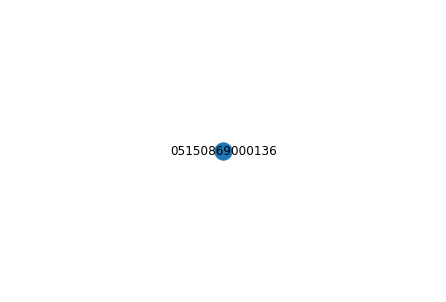

In [29]:
nx.draw(G, with_labels=True)

In [29]:
G = None

In [ ]:
try:
    with open('viz/template.html', 'r', encoding='utf-8') as template:
        str_html = template.read().replace('<!--GRAFO-->', json.dumps(rede.json()))
        
    path_html = os.path.join(path_output, 'grafo.html')
    with open(path_html, 'w', encoding='utf-8') as html:
        html.write(str_html)

    if config.PATH_NAVEGADOR:
        subprocess.Popen([config.PATH_NAVEGADOR, os.path.abspath(path_html)])

except Exception as e:
    print('Não foi possível gerar a visualização. [{}]'.format(e))